In [ ]:
# install the package 
!pip install qiskit
!pip install pylatexenc

     |████████████████████████████████| 6.5 MB 4.1 MB/s 
     |████████████████████████████████| 18.0 MB 225 kB/s 
     |████████████████████████████████| 240 kB 40.9 MB/s 
     |████████████████████████████████| 200 kB 45.7 MB/s 
     |████████████████████████████████| 111 kB 45.0 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 1.6 MB 14.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 943 kB 45.2 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 3.6 MB 37.0 MB/s 
     |████████████████████████████████| 113 kB 36.0 MB/s 
  Created wheel for qiskit: filename=qiskit-0.36.0-py3-none-any.whl size=11861 sha256=9ca4fa59525f22e16637a56b9ce034da98778e9a6a818a4b78a127384d4e08d4
  Stored in directory: /root/.cache/pip/whee

In [ ]:
! pip install h5py

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # If you didn't save the parameter.dat and ansatz.h5 files on google drive, you don't need to run this cell

Mounted at /content/gdrive


In [ ]:
path='' # The path you save the parameter.dat and ansatz.h5 files. 

# 1 Introduction
## 1-1 Quantum Simulation
One of the leading uses for quantum computers will be to simulate quantum systems such as molecules or engineered materials. Actually executing a quantum simulation on a current quantum computer, however, can be difficult and error prone. Your objective for this Open Science Prize is to significantly improve the state-of-the-art for quantum simulation (details in Section 2).

The quantum system you will simulate is a quantum spin-1/2 model, where each qubit represents a quantum spin-1/2 particle in a 1D chain. Quantum spin models have some amazing properties and uses. Computationally speaking, certain optimization problems can be mapped to spin models and hence minimized on a quantum computer. Physically speaking, spin models show a variety of quantum behavior such as large entangled states, quantum phases of matter, quantum many-body affects, and many other open questions in physics research.

There are many different spin models, but we will focus on the $XXX$ Heisenberg spin model. Though it is not as well known as the transverse-field Ising model, the $XXX$ Heisenberg model is of practical and theoretical interest. It can also be difficult to simulate, which is where you come in.

The notebook is organized as follows: 1) Section 1 (labeled 1-X) provides you with brief introductions to the $XXX$ Heisenberg model, time evolving a Hamiltonian, and decomposing a time evolution operator into gates for a quantum computer to execute. 2) Section 2 (labeled 2-X) outlines the specific requirements and boundaries associated with completing and competing in the Open Science Prize. Continuing from Section 1, the notebook showns an example solution.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

import qiskit

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
import math
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [ ]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

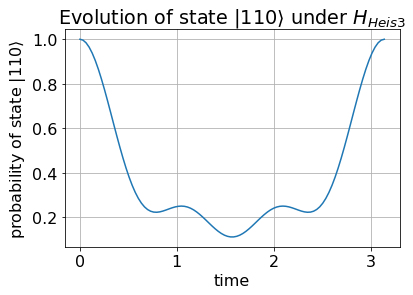

In [ ]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero


# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

In [ ]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Qiskit Pulse imports
import qiskit.pulse
from qiskit import pulse
from qiskit.pulse import library

from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag

from scipy.special import erf

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load IBMQ Account data
IBMQ.save_account('',overwrite=True )
IBMQ.load_account()



<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:

provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

backend  = provider.get_backend('ibmq_jakarta')

properties = backend.properties()

In [ ]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

In [ ]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [ ]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

In [ ]:
# Use optimized pulse

# The PassManager helps decide how a circuit should be optimized
# (https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html)
from qiskit.transpiler import PassManager

# This function will pull pulse-level calibration values to build RZX gates and tell the PassManager to leave RZX gates alone
from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho

# Load the variational parameters and the corresponding operators

In [ ]:
params_file=path+'/params_trace_pi.dat' # Find the variational parameters
ansatz_file=path+'/ansatz_pi.h5'        # The corresponding operators

In [ ]:
import h5py
f_ansatz= h5py.File(ansatz_file, 'r') # open h5 file

In [ ]:
def rzz_qiskit(qc,angle,q1,q0): # Using non-echo Rzx gate to create Rzz gate 
    qc.ry(-np.pi/2,q0)
    qc.rzx(angle/2, q1, q0) # non-echo Rzx gate
    qc.x(q1)             # X \pi echo pulse
    qc.rzx(-angle/2, q1, q0) # non-echo Rzx gate
    qc.x(q1)
    qc.ry(np.pi/2,q0)

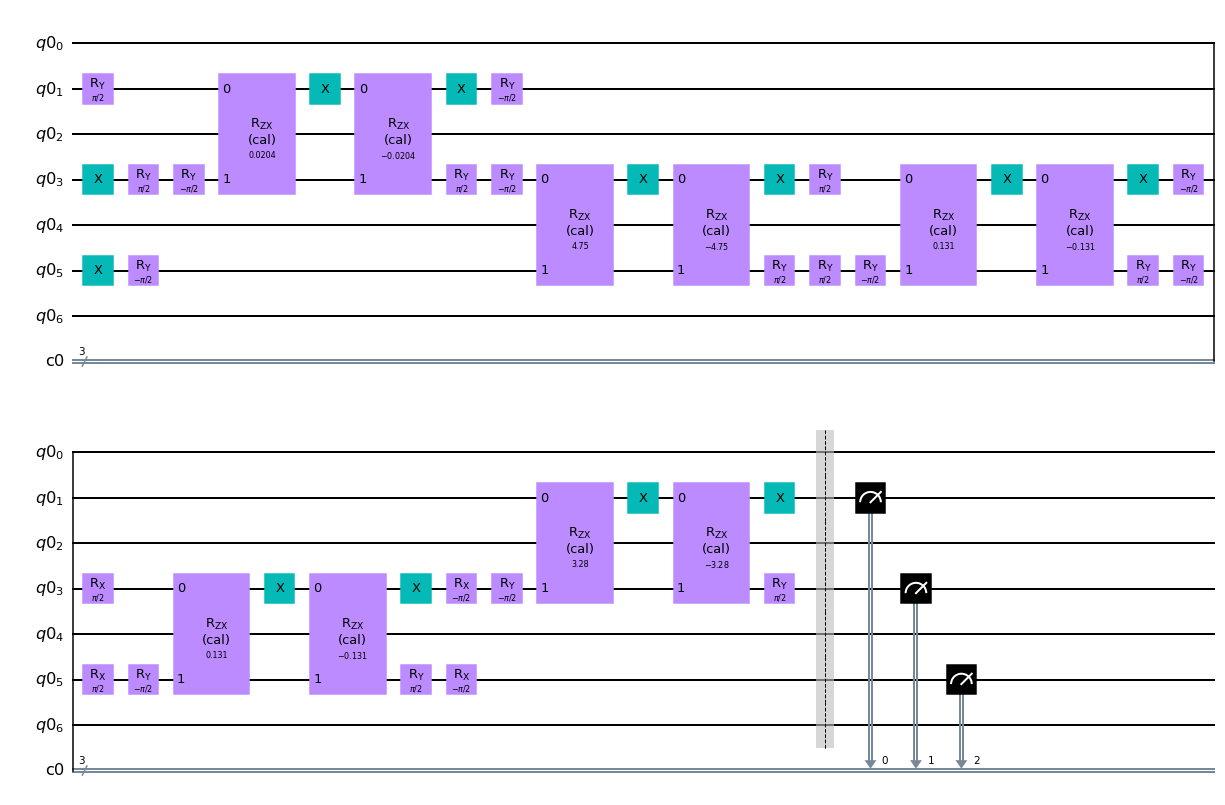

In [ ]:
target_time = np.pi 

target_t=np.pi # the evolution time we want to get 
f = open(params_file, "r") # open the variational parameters file
num_string = f.readline()
pi_closer = 0
del_num = 1000
while num_string != '': # find out variational parameters when t=target_t
    num = num_string.split()
    time = float(num[0])
    if min(del_num,np.abs(time-target_t))==del_num:
        pass
    else:
        del_num=np.abs(time-target_t)
        pi_closer=time
        params=num[1:]
    num_string = f.readline()


# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

qlst=[1,3,5] # Use 1,3,5 circuits

q0=qlst[0]

q1=qlst[1]

q2=qlst[2]


for i,op in enumerate(f_ansatz['ansatz_code'][:,:]):
    if op[1]==3:
      # op[1]=3: means Rzz gate
        rzz_qiskit(qc,float(params[i]),qlst[op[0]],qlst[op[2]])
    elif op[1]==2:
      # op[1]=2: means Ryy gate
        qc.rx(np.pi/2,[qlst[op[0]],qlst[op[2]]])
        rzz_qiskit(qc,float(params[i]),qlst[op[0]],qlst[op[2]])
        qc.rx(-np.pi/2,[qlst[op[0]],qlst[op[2]]])
    elif op[1]==1:
      # # op[1]=1: means Rxx gate
        qc.ry(np.pi/2,[qlst[op[0]],qlst[op[2]]])
        rzz_qiskit(qc,float(params[i]),qlst[op[0]],qlst[op[2]])
        qc.ry(-np.pi/2,[qlst[op[0]],qlst[op[2]]])


# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[q0], qr[q1], qr[q2]])

pm = PassManager([RZXCalibrationBuilderNoEcho(backend)])
st_qcs_pulse_efficient = pm.run(st_qcs)
st_qcs_pulse_efficient[-1].draw('mpl') # optimized the pulse sequence


In [ ]:
def DD_circuit_qiskit_pulse(circuit, backend, qubits_list, initial_layout = None, name=False):
  """

  Dynamical decoupling X_\pi-X_-\pi 


  circuit: qiskit circuit

  backend: ibm device

  qubits_list: the qubit list used to run 

  name: 'the circuit name'

  """

  if initial_layout:

    circuit = transpile(circuit, backend, scheduling_method='asap',initial_layout =init_layout)

  else:

    circuit = transpile(circuit, backend, scheduling_method='asap')

  if name:

    DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs,name=circuit.name)

  else:

    DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs)
  
  for operation in circuit[:]:

    if type(operation[0])==qiskit.circuit.delay.Delay:

      if  operation[0].duration >= 400:

        q_index = operation[1][0].index

        if q_index in qubits_list:

          t=(operation[0].duration-320)//4 

          t = math.ceil((t)/16)*16 # must be the multiple of 16

          DD_cir.delay(t,[q_index],'dt')

          DD_cir.x(q_index) # X_\pi 

          DD_cir.delay(2*t,[q_index],'dt')

          DD_cir.z(q_index) # Z gate won't contribute time in ibm device

          DD_cir.x(q_index) # X_-\pi

          DD_cir.z(q_index)  # Z gate won't contribute time in ibm device

        else:

          DD_cir.data.append(operation)

      else:
        
        DD_cir.data.append(operation)

    else:

      DD_cir.data.append(operation)

  # To optimized the pulse again

  pm = PassManager([RZXCalibrationBuilderNoEcho(backend)]) 
  DD_cir_pulse_efficient = pm.run(DD_cir)

  return DD_cir_pulse_efficient

In [ ]:
from qiskit import *

In [ ]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [ ]:
qubits_list = [1,3,5]

cirs=[]

# create the circuits w/ dynamical decoupling.
for i in range(len(st_qcs)):

    cir_pulse_efficient=DD_circuit_qiskit_pulse(st_qcs_pulse_efficient[i], backend, qubits_list, name=True )

    cirs.append(cir_pulse_efficient)

In [ ]:
# Using complete readout error mitigation
qubits_list = [q0,q1,q2]

shots=8192

qr = QuantumRegister(len(qubits_list),'q')

meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [ ]:
# Execute the readout error mitigation circuits first
init_layout = {}

for i,j in enumerate(qubits_list):

    init_layout[qr[i]] = j

cal_results = execute(meas_calibs, backend, shots=shots, initial_layout=init_layout)

print('Job ID', cal_results.job_id())

Job ID 624cf6f6182d0264174c1d8b


In [ ]:
shots = 8192
reps =8

backend = backend 

jobs = []
for _ in range(reps):
    # execute state tomography circuits
    job = execute(cirs, backend, shots=shots)
    
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 624cf6facaa265439af18d92
Job ID 624cf6fd5ab79bc22af94560
Job ID 624cf70073968c7dec07a6b6
Job ID 624cf70273968c4e5707a6b7
Job ID 624cf706182d02762a4c1d8d
Job ID 624cf709d72033ee1567cc01
Job ID 624cf70ccaa2658fb7f18d94
Job ID 624cf70f5ab79b306af94562


In [ ]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job is queued (536)

# Job Retrieve

In [ ]:
# The history result


# Readout error mitigation result
cal_results=backend.retrieve_job('624cf6f6182d0264174c1d8b')

# State tomography result
ids=['624cf6facaa265439af18d92','624cf6fd5ab79bc22af94560','624cf70073968c7dec07a6b6','624cf70273968c4e5707a6b7',
     '624cf706182d02762a4c1d8d','624cf709d72033ee1567cc01','624cf70ccaa2658fb7f18d94','624cf70f5ab79b306af94562']
jobs=[]
for id in ids:
  jobs.append(backend.retrieve_job(id))

In [ ]:
# get readout error filter
meas_fitter = CompleteMeasFitter(cal_results.result(), state_labels)

meas_filter = meas_fitter.filter

In [ ]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs): #, time):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    initial_state = One^One^Zero

    #target_state = (U_heis3(float(time)) @ initial_state).eval().to_matrix()

    mit_result = meas_fitter.filter.apply(result)

    tomo_fitter = StateTomographyFitter(mit_result, st_qcs)

    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition

fids = []

for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids))) 

state tomography fidelity = 0.9342 ± 0.0025


In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table